In [10]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/MonteCarlo-Statistical-Methods


In [11]:
from functools import partial
from sampling.exponential import *
from utils.montecarlo import *
from matplotlib import pyplot as plt
from utils.randomVariable import *
import scipy.stats as scistats
import matplotlib

## Exponential Distribution

The Exponential distribution is the simplest continuous one-parameter model on $x>0$ and an essential testbed for Monte Carlo simulation.
It is defined by 
$$
P_X(x) = \begin{cases}
    \frac{1}{\lambda} e^{-\frac{x}{\lambda}} & \hspace{0.3cm} if \hspace{0.2cm} x >=0\\
    0 & \hspace{0.3cm} otherwise
\end{cases}
$$
where the scale parameter $\lambda > 0$ is equal to the true mean and the standard deviation:\\
$\mathbb{E}[X] = \lambda$, $Var(X) = \lambda^2$

## Random Variable Generation

To generate samples from the Exponential distribution, we use the **Inverse Transform Sampling** method.  
Given a continuous random variable \( X \) with cumulative distribution function \( F_X(x) \), if \( U \sim U(0,1) \), then

$$
X = F_X^{-1}(U)
$$

has the same distribution as \( X \).

### Derivation of the Inverse Transform

For the exponential density

$$
P_X(x) = \frac{1}{\lambda} e^{-\frac{x}{\lambda}}, \quad x \ge 0
$$

the cumulative distribution function is

$$
\begin{align*}
F_X(x)
&= \int_{0}^{x} \frac{1}{\lambda} e^{-\frac{t}{\lambda}}\,dt \\
&= \frac{1}{\lambda} \left[-\lambda e^{-\frac{t}{\lambda}}\right]_0^{x} \\
&= 1 - e^{-\frac{x}{\lambda}}
\end{align*}
$$

Let \( U = F_X(x) \). Then

$$
U = 1 - e^{-\frac{x}{\lambda}} \implies x = -\lambda \ln(1 - U)
$$

Hence, the random variable generation formula is:

$$
X = -\lambda \ln(1 - U), \quad U \sim U(0,1)
$$

Since \( 1 - U \) is also uniform on \((0,1)\), we commonly write

$$
X = -\lambda \ln(U)
$$


### Inverse Transform Algorithm

To generate $n$ i.i.d. samples from $\mathrm{Exp}(\lambda)$:

1. Generate $U_i \sim U(0,1)$ for $i = 1, \dots, n$.
2. Compute  
   $$X_i = -\lambda \ln U_i$$

Then $\{ X_i \}_{i=1}^{n}$ are i.i.d. draws from the exponential distribution with the scale parameter $\lambda$.  

This exact inverse-transform relationship makes the Exponential distribution ideal for validating Monte Carlo estimators and convergence results in later sections.

## Monte Carlo Verification

We generate samples using the inverse-transform function and compare the simulated distribution with the theoretical one to verify correctness.

In [12]:
num_samples = 10000
lambda_parameter = 2
exponential_samples = sample_exponential(lambda_parameter, num_samples)

The histogram of the simulated samples aligns closely with the theoretical probability density function, confirming that the inverse-transform sampling is implemented correctly.

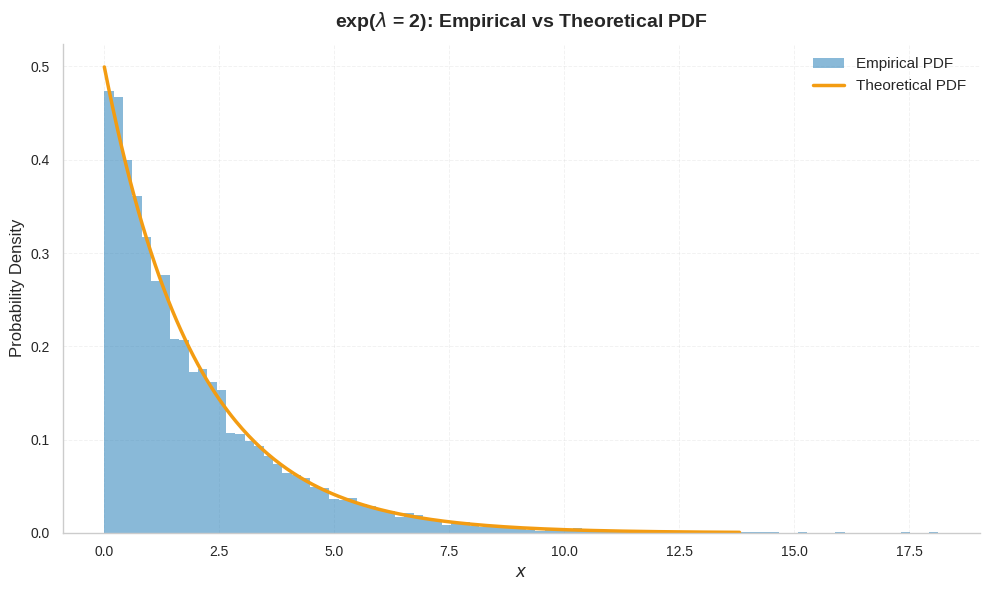

In [13]:
expon_rv = scistats.expon(scale=lambda_parameter)
save_path_1 = os.path.join(ROOT, "images/sampling/EmpvsTheo_exp.png")
plot_empirical_and_theoretical_pdf(exponential_samples,expon_rv,dist_name=f"exp($\lambda$ = {lambda_parameter})",save_path=save_path_1)

## Convergence Demonstrations

The **Law of Large Numbers (LLN)** states that as the number of trials in a random experiment increases, the sample mean (average) of the outcomes approaches the expected value of the random variable. 

In mathematical terms, if $X_1, X_2, X_3, \dots, X_n \overset{\mathrm{iid}}{\sim} X$, where $X$ is a random variable with a finite expected value $\mathbb{E}[X] < \infty$, then the sample mean

$$
\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_i
$$

converges in probability to $\mathbb{E}[X]$ as $n \to \infty$.

This convergence implies that the larger the sample size $n$, the closer $\bar{X}_n$ will be to $\mathbb{E}[X]$, giving $\mathbb{E}[X]$ an operational meaning as the long-term average of the random variable $X$.


### Weak Law of Large Numbers (WLLN)

The **Weak Law of Large Numbers** states that as the sample size $n$ increases, the sample mean $\bar{X}_n$ becomes increasingly concentrated around the true mean $\mathbb{E}[X]$.

Let $X_1, X_2, \dots, X_n \overset{\mathrm{iid}}{\sim} X$ with $\mathbb{E}[X] = \mu$ and $\mathrm{Var}(X) = \sigma^2 < \infty$.  
Define the sample mean:

$$
\bar{X}_n = \frac{1}{n} \sum_{i=1}^{n} X_i
$$

Then,

$$
\mathbb{E}[\bar{X}_n] = \mu, \qquad \mathrm{Var}[\bar{X}_n] = \frac{\sigma^2}{n}
$$

As $n \to \infty$, the variance $\mathrm{Var}[\bar{X}_n]$ approaches zero, implying that the distribution of $\bar{X}_n$ becomes more and more concentrated around its mean.  
Formally,

$$
\bar{X}_n \xrightarrow[n \to \infty]{p} \mu
$$

that is, for every $\epsilon > 0$,

$$
\lim_{n \to \infty} \mathbb{P}\big(|\bar{X}_n - \mu| > \epsilon\big) = 0
$$

Intuitively, if we repeat the same experiment many times, each time drawing $n$ samples and computing their mean, we obtain a distribution of sample means.  
For small $n$, this distribution is wide and variable; for large $n$, it becomes sharply peaked around $\mathbb{E}[X]$.  
In the limit as $n \to \infty$, this sampling distribution collapses into a *constant (degenerate) distribution* at $\mathbb{E}[X]$, meaning that all probability mass accumulates at the true mean.  

Hence, $\bar{X}_n$ converges *in probability* to $\mathbb{E}[X]$, and the sample mean behaves increasingly like a deterministic quantity as $n$ grows.


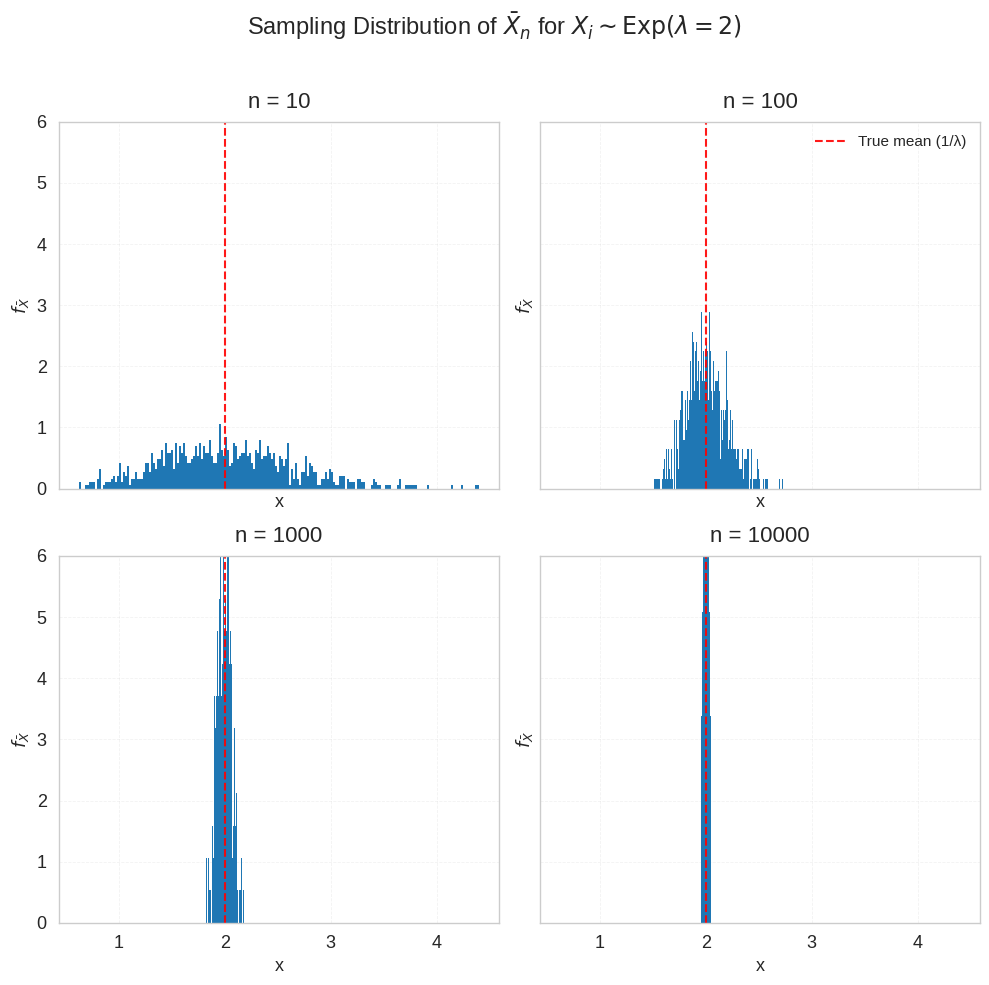

In [14]:
exp_gen = partial(sample_exponential, lambda_parameter)
nsamples = np.array([[10, 100], [1000, 10000]])
ntrials = 1000
true_mean = lambda_parameter

# plt.style.use('seaborn-v0_8-talk')
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, n in np.ndenumerate(nsamples):
    estimates = sampling_distribution(n, ntrials, exp_gen, lambda x: x)
    
    axs[i].hist(estimates, bins=200, density=True)
    # True mean line
    axs[i].axvline(true_mean, color='red', lw=1.5, linestyle='--', alpha=0.9, label='True mean (1/λ)')
    
    axs[i].set_title(f"n = {n}", fontsize=16, pad=10)
    axs[i].set_xlabel("x", fontsize=13)
    axs[i].set_ylabel("$f_{\\bar{X}}$", fontsize=13)
    axs[i].grid(alpha=0.25, linestyle='--', linewidth=0.6)
    axs[i].set_ylim(0, 6)

fig.suptitle(r"Sampling Distribution of $\bar{X}_n$ for $X_i \sim \mathrm{Exp}(\lambda=2)$",
             fontsize=17, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
# Legend (once, in upper right subplot)
axs[0, 1].legend(frameon=False, fontsize=11, loc='best')
save_path_2 = os.path.join(ROOT, "images/sampling/WLLN_exp.png")
fig.savefig(save_path_2, dpi=300, bbox_inches='tight')
plt.show()

### Strong Law of Large Numbers (SLLN)

The **Strong Law of Large Numbers (SLLN)** strengthens the result of the Weak Law by asserting a more powerful mode of convergence:  
the sample mean $\bar{X}_n$ converges to the true mean $\mathbb{E}[X]$ *almost surely* (a.s.), that is, with probability one.

Let $X_1, X_2, \dots, X_n \overset{\mathrm{iid}}{\sim} X$ with $\mathbb{E}[X] = \mu$ and $\mathrm{Var}(X) = \sigma^2 < \infty$.  
Define the running sample mean:

$$
\bar{X}_n = \frac{1}{n} \sum_{i=1}^{n} X_i
$$

Then, by the Strong Law of Large Numbers,

$$
\bar{X}_n \xrightarrow[n \to \infty]{a.s.} \mu
$$

that is, for every $\epsilon > 0$,

$$
\mathbb{P}\!\left(\lim_{n \to \infty} \big|\bar{X}_n - \mathbb{E}[X]\big| > \epsilon \right) = 0, 
\quad \forall \epsilon > 0
$$

In words, the probability that the running average $\bar{X}_n$ ever deviates from the true mean $\mathbb{E}[X]$ by more than $\epsilon$ after some point $n$ becomes zero as $n \to \infty$.  
Equivalently, the probability that a sequence *fails* to converge to the true mean is zero, or said another way, the probability that it *does* converge to $\mathbb{E}[X]$ is one.

Intuitively, this theorem states that if we observe a single sufficiently long sequence of outcomes from a random process, the cumulative average will settle down to the expected value.  
Although individual observations fluctuate, their long-term average becomes nearly constant — a concrete manifestation of *stability through repetition*.

The figure below shows this phenomenon for $X_i \sim \mathrm{Exp}(\lambda = 2)$.  
Each curve represents a running mean trajectory computed from an independent sequence of samples.  
As $n$ increases, all trajectories approach and remain close to the true mean $\mathbb{E}[X] = \lambda = 2$, illustrating convergence almost surely.


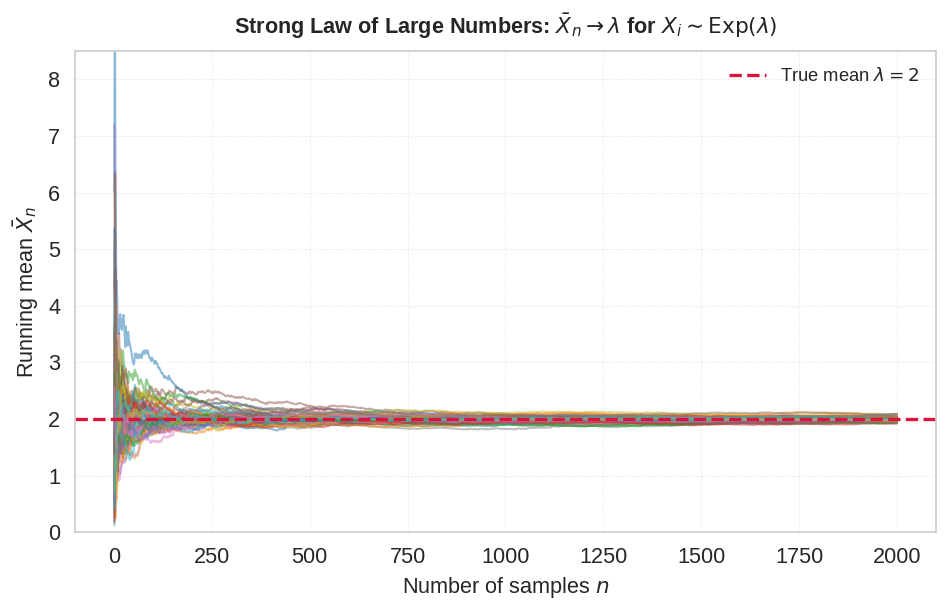

In [15]:
exp_gen = partial(sample_exponential, lambda_parameter)
n = 2000
n_indep_replicates = 50
nsample_arr = np.arange(1, n + 1)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 5.2), dpi=120)
for _ in range(n_indep_replicates):
    mc_exp = monte_carlo(n, exp_gen, lambda x: x, cumsum=True)
    plt.plot(nsample_arr, mc_exp.estimate, lw=1.2, alpha=0.5)

# --- True mean line ---
plt.axhline(y=lambda_parameter, color='crimson', lw=2.0, linestyle='--', label=r'True mean $\lambda=2$')

# --- Labels and title ---
plt.xlabel(r'Number of samples $n$', fontsize=13)
plt.ylabel(r'Running mean $\bar{X}_n$', fontsize=13)
plt.title(r'Strong Law of Large Numbers: $\bar{X}_n \to \lambda$ for $X_i \sim \mathrm{Exp}(\lambda)$',
          fontsize=13, weight='semibold', pad=10)

# --- Subtle grid and limits ---
plt.grid(alpha=0.3, linestyle='--', linewidth=0.6)
plt.ylim(0, 8.5)
plt.legend(frameon=False, fontsize=11, loc='best')

plt.tight_layout()
save_path_3 = os.path.join(ROOT, "images/sampling/SLLN_exp.png")
plt.savefig(save_path_3, dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

### Difference between WLLN and SLLN

The **Weak Law of Large Numbers (WLLN)** and **Strong Law of Large Numbers (SLLN)** both assert that the sample mean approaches the true mean as $n$ increases, but they differ in the *mode of convergence*:

- **WLLN – Convergence in probability:**  
  The fraction of realizations where $\bar{X}_n$ deviates from $\mathbb{E}[X]$ by more than $\epsilon$ becomes negligible as $n$ increases.

  $$
  \forall \epsilon > 0, \quad 
  \mathbb{P}\big(|\bar{X}_n - \mathbb{E}[X]| > \epsilon\big) \to 0
  $$

- **SLLN – Convergence almost surely:**  
  Every observed realization (sequence) of the process will eventually settle at $\mathbb{E}[X]$, except possibly for a set of measure zero.

  $$
  \mathbb{P}\!\left(\lim_{n \to \infty} \bar{X}_n = \mathbb{E}[X]\right) = 1
  $$

In short:  
- The **WLLN** ensures that *most samples are close to the truth most of the time*.  
- The **SLLN** guarantees that *every single sample path eventually converges to the truth*.

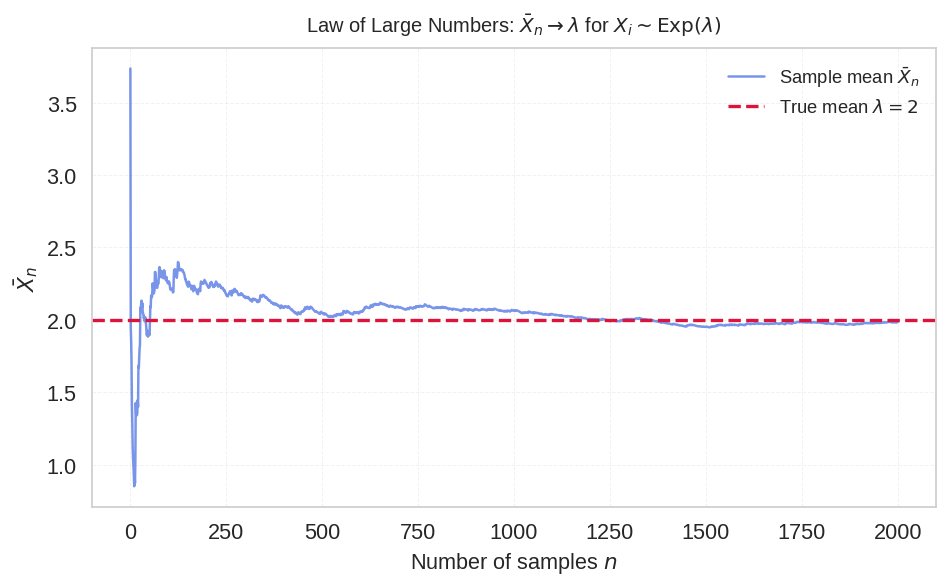

In [16]:
mc_exp = monte_carlo(2000, exp_gen, lambda x: x, cumsum=True)
nsample_arr = np.arange(1, mc_exp.estimate.shape[0] + 1) # an array of numbers form 1,2,...,nsamples

# Plot
plt.figure(figsize=(8, 5), dpi=120)
plt.plot(nsample_arr, mc_exp.estimate, color='royalblue', lw=1.5, alpha=0.7, label=r'Sample mean $\bar{X}_n$')
plt.axhline(y=2, color='crimson', lw=2.0, linestyle='--', label=r'True mean $\lambda=2$')


# Labels & title
plt.xlabel(r'Number of samples $n$', fontsize=13)
plt.ylabel(r'$\bar{X}_n$', fontsize=13)
plt.title(r'Law of Large Numbers: $\bar{X}_n \rightarrow \lambda$ for $X_i \sim \mathrm{Exp}(\lambda)$',
          fontsize=12, pad=10)

# Aesthetics
plt.grid(alpha=0.25, linestyle='--', linewidth=0.6)
plt.legend(frameon=False, fontsize=11, loc='best')
plt.tight_layout()

# Optional: use a nice style
plt.style.use('seaborn-v0_8-talk')
plt.show()

## Central Limit Theorem (CLT)

The **Central Limit Theorem (CLT)** provides a probabilistic bridge between an arbitrary distribution and the normal distribution.  

Let $X_1, X_2, \dots, X_n \overset{\mathrm{iid}}{\sim} X$ with $\mathbb{E}[X] = \mu$ and $\mathrm{Var}(X) = \sigma^2 < \infty$.  
Then, as $n \to \infty$, the standardized sample mean

$$
Z_n = \frac{\sqrt{n}\,(\bar{X}_n - \mu)}{\sigma}
$$

converges in distribution to the standard normal:

$$
Z_n \xrightarrow{d} \mathcal{N}(0,1)
$$

This result implies that, regardless of the original shape of the population distribution, the sampling distribution of the standardized mean becomes approximately normal for sufficiently large $n$.  
In other words, random variation in averages exhibits a universal Gaussian pattern.

For the Exponential distribution $X_i \sim \mathrm{Exp}(\lambda = 2)$, we have $\mu = \lambda$ and $\sigma = \lambda$.  
The figure below illustrates the convergence of the sampling distribution of the standardized mean to the standard normal as $n$ increases.

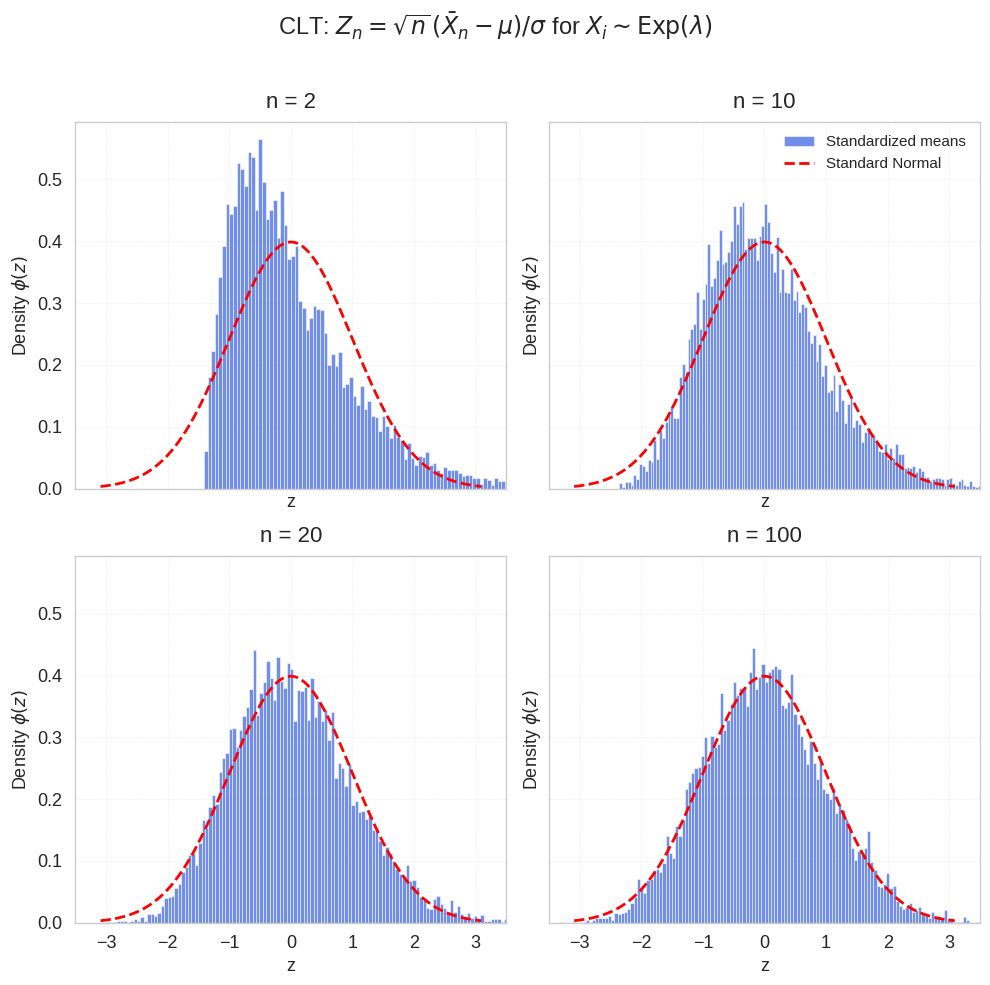

In [17]:
exp_gen = partial(sample_exponential, lambda_parameter)
nsamples = np.array([[2, 10], [20, 100]])
ntrials = 10000
true_mean = lambda_parameter
std_deviation = lambda_parameter

# plt.style.use('seaborn-v0_8-talk')
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

# Standard normal overlay (theoretical)
ppm_thresh = 1e-3
N = 300
x = np.linspace(scistats.norm.ppf(ppm_thresh), scistats.norm.ppf(1 - ppm_thresh), N)
norm_pdf = scistats.norm.pdf(x)

for i, n in np.ndenumerate(nsamples):
    z_estimates = normalize_sampling_distribution(n, ntrials, exp_gen, lambda x: x, true_mean, std_deviation)
    
    axs[i].hist(z_estimates, bins=150, density=True,
                color='royalblue', alpha=0.75, edgecolor='white', linewidth=0.5,
                label='Standardized means')
    axs[i].plot(x, norm_pdf, 'r--', lw=2, label='Standard Normal')
    
    axs[i].set_xlim(-3.5, 3.5) # common z-range
    axs[i].set_title(f"n = {n}", fontsize=16, pad=10)
    axs[i].set_xlabel("z", fontsize=13)
    axs[i].set_ylabel(r"Density $\phi(z)$", fontsize=13)
    axs[i].grid(alpha=0.25, linestyle='--', linewidth=0.6)

# Title + layout
fig.suptitle(r"CLT: $Z_n=\sqrt{n}\,(\bar{X}_n-\mu)/\sigma$ for $X_i \sim \mathrm{Exp}(\lambda)$",
             fontsize=17, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Legend once (upper-right panel)
axs[0, 1].legend(frameon=False, fontsize=11, loc='best')

# Save
save_path_4 = os.path.join(ROOT, "images/sampling/CLT_exp.png")
plt.savefig(save_path_4, dpi=300, bbox_inches="tight", facecolor='white')
plt.show()